# Preprocessing

In [1]:
import os
import cv2
import numpy as np

IMG_SIZE = 128  # or whatever size you want

def load_data(image_dir, mask_dir):
    images, masks = [], []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Missing or unreadable: {img_path} or {mask_path}")
            continue

        # Resize both image and mask
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Normalize image
        img = img / 255.0

        # Threshold mask to binary: 0 or 1
        _, mask = cv2.threshold(mask, 10, 1, cv2.THRESH_BINARY)

        # Expand mask to have shape (H, W, 1)
        mask = mask[..., np.newaxis]

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


# Visualisation

In [2]:
import matplotlib.pyplot as plt

def show_image(images, masks, n=5):
    plt.figure(figsize=(10, 2 * n))
    
    for i in range(n):
        # Show image
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Show corresponding mask
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [5]:
images, masks = load_data("/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images", "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks")


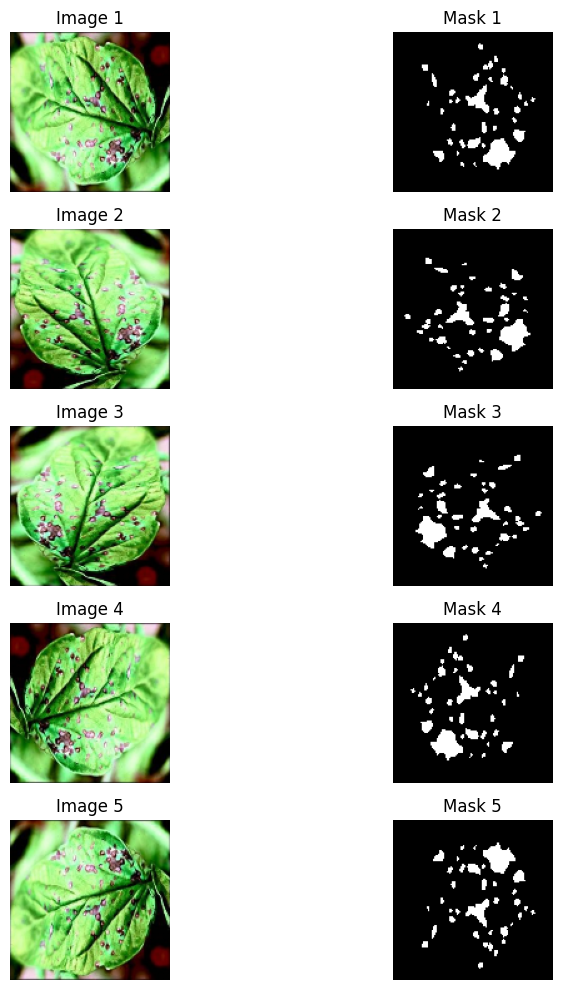

In [6]:
show_image(images, masks)


# U-net model

In [7]:
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    
    # Contracting path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Expanding path (Decoder)
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3], axis=-1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1], axis=-1)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = models.Model(inputs, outputs)
    return model


2025-05-15 13:14:02.572238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747314842.790484      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747314842.859015      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [26]:
from tensorflow.keras.optimizers import Adam

model = unet_model(input_size=(128, 128, 3))

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


# Training

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50,
                    callbacks=[EarlyStopping(patience=5)],
                    batch_size=16)


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - accuracy: 0.8306 - loss: 0.5255 - val_accuracy: 0.8321 - val_loss: 0.3443
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.8536 - loss: 0.3262 - val_accuracy: 0.8705 - val_loss: 0.3035
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.8741 - loss: 0.2989 - val_accuracy: 0.8775 - val_loss: 0.2873
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.8843 - loss: 0.2761 - val_accuracy: 0.8845 - val_loss: 0.2713
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.8908 - loss: 0.2628 - val_accuracy: 0.8895 - val_loss: 0.2637
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.8932 - loss: 0.2576 - val_accuracy: 0.8910 - val_loss: 0.2602
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.8894 - loss: 0.2585 - val_accuracy: 0.8963 - val_loss: 0.2480
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.8997 - loss: 0

# Evaluation

In [28]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9485 - loss: 0.1476
Validation Loss: 0.15407267212867737
Validation Accuracy: 0.9466838240623474


# Plot valuation metrics

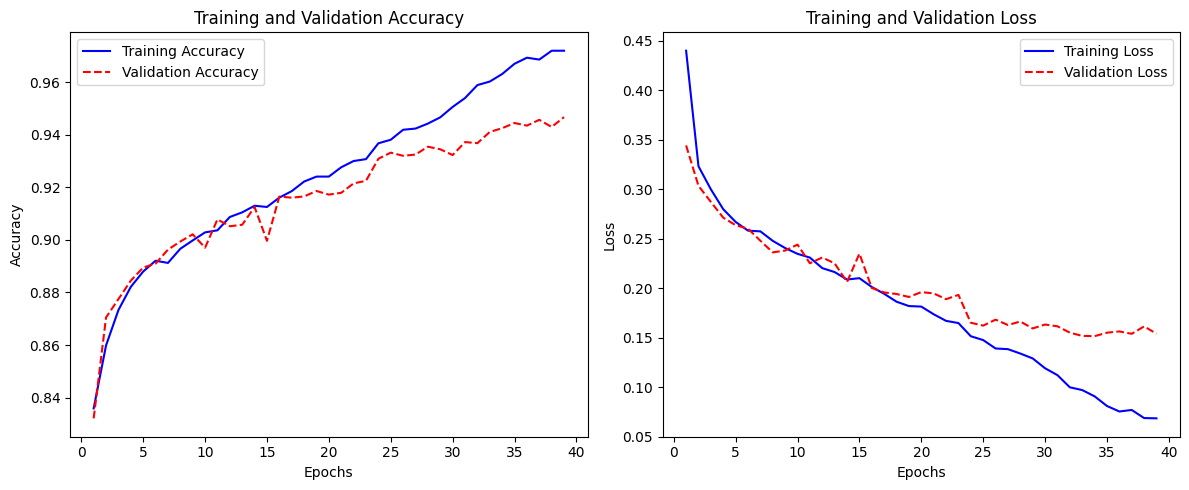

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your history object
plot_training_history(history)


# Visualize Predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


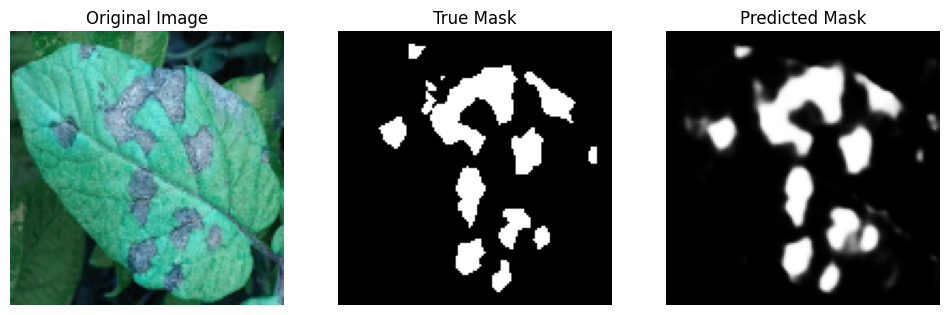

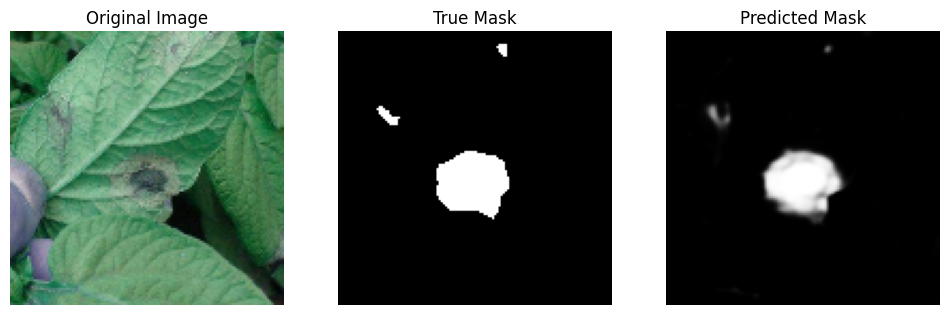

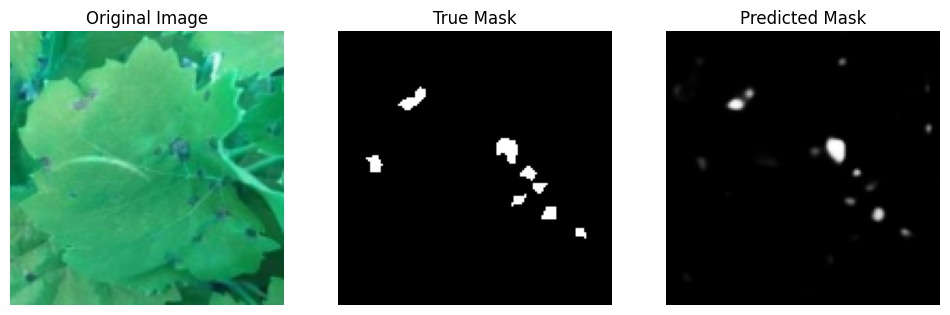

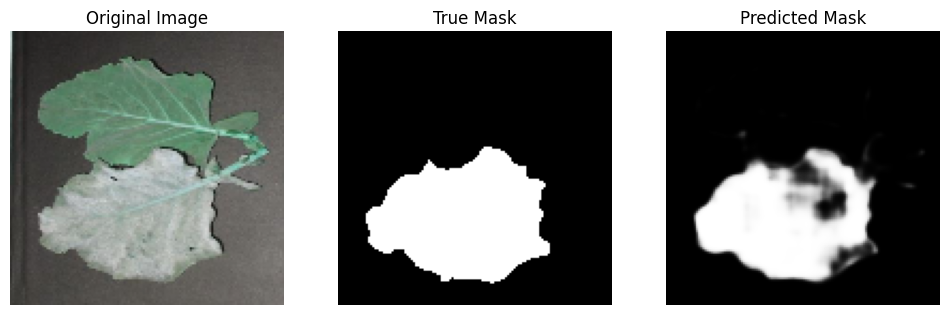

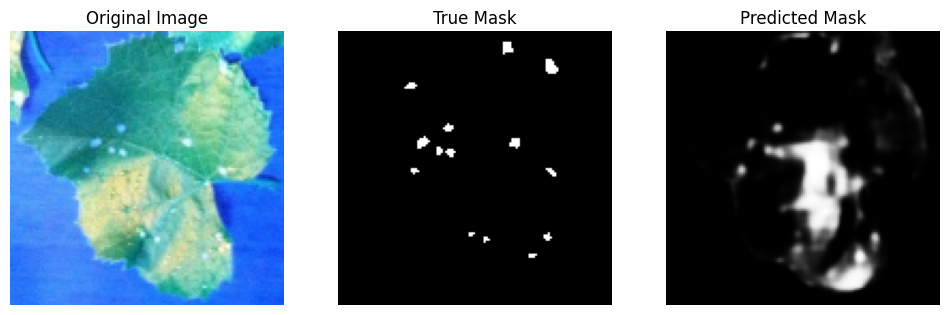

In [30]:
import matplotlib.pyplot as plt

# Predict on validation set
predictions = model.predict(X_val)

# Display original image, mask, and prediction
for i in range(5):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()


In [31]:
model.save('unet_model.h5')

In [35]:
from IPython.display import FileLink

FileLink('/kaggle/working/unet_model.h5')


/kaggle/working/unet_model.h5

In [34]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/unet_model.h5')
